# Processing steps for SNR observed in PN Large Window mode

In [1]:
import os
import subprocess
import sys
import glob
import logging

import numpy as np

from astropy.io import fits
from astropy.stats import mad_std

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
def run_command(command,verbose=True):
    #
    # Execute a shell command with the stdout and stderr being redirected to a log file 
    #
    try:
        result = subprocess.run(command, shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode=result.returncode
        if retcode < 0:
            if (verbose):
                print(f"Execution of {command} was terminated by signal", -retcode, file=sys.stderr)
            logging.warning("Execution of {} was terminated by signal: {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            if (verbose):
                print(f"Execution of {command} returned", retcode, file=sys.stderr)
            logging.info("Execution of {} returned {}, \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
        logging.error("Execution of {} failed: {}".format(command,e))
    return retcode

## Setting up XMM-SAS

For some reason, running the ipython magic command `!. /home/xcaldata/setsas_161.sh`, does not propagate to the session, i.e. although it prints out that SAS is set up, it is not available after the execution of the shell command. So, I have to do it manually, by setting some environment variables.

The last line in the next cell, `!sasversion` should work.

In [3]:
#
# set up XMM-SAS
#
# the current one is 18.0 ==> /home/xcaldata/setsas_180.sh
# tests with XMM-SAS 16.1 for the arfgen
#!. /home/xcaldata/setsas_161.sh
#
sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas16_1_0"
os.environ["SAS_DIR"]= sas_dir
os.environ["SAS_PATH"]=os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"]="4"
os.environ["SAS_SUPPRESS_WARNING"]="1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
ld_path = os.environ["LD_LIBRARY_PATH"]
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
os.environ["LD_LIBRARY_PATH"] = lib_path
#
# check
#print ("PATH = ",os.environ["PATH"])
#print ("LF_LIBRARY_PATH = ",os.environ["LD_LIBRARY_PATH"])
#for ikey in os.environ.keys():
#    if ('SAS' in ikey):
#        print (ikey," = ",os.environ[ikey])
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2019-06-28T10:54:11.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:08 CEST 2019
Compiled by: sasbuild@sasbld01n.net4.lan
Platform   : RHEL6.8 64

SAS-related environment variables that are set:

SAS_DIR = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_PATH = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_CCFPATH = /xdata/ccf/pub

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2019-06-28T10:54:11.000


## Processing of a target

Next cell sets up the target name, the XMM `OBS_ID` and the different paths. I usually keep the following structure in the `root_dir`:
```
<target>
   <OBS_ID 1>
       <proc>
   <OBS_ID 2>
       <proc>
   ...
```
where in folders `<OBS_ID>` I keep the ODF files and the CCF file. While in `<proc>` I keep the processing products, like event lists, images etc. The spectral extraction regions are also kept in `<proc>` folder.

For processing with different versions of SAS or calibration, I use different names for the `<proc>` folders.

In [4]:
#
# set up the paths, the target and the OBS_ID
#
root_dir = "/xdata/xcaldata/XMM/IVAN/PN_LW/sources"
#root_dir = "/lhome/ivaltchanov/XMM-clusters"
target="PuppisA"
obsid="0150150301"
#target="A2029"
#obsid="0551780301"
#target="A3571"
#obsid="0086950201"
#target="Coma"
#obsid="0300530101"

# the output processing will be saved to a folder proc_161
pps="proc_18"
odf_dir = f"{root_dir}/{target}/{obsid}"
#
if (not os.path.isdir(odf_dir)):
    print (f"{odf_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Found ODF folder: {odf_dir}.")
#
pps_dir = f"{root_dir}/{target}/{obsid}/{pps}"
if (not os.path.isdir(pps_dir)):
    print (f"{pps_dir} does not exist. Will create it.")
    os.mkdir(pps_dir)
else:
    print (f"Will use {pps_dir} for the products.")
#
#
# logging to file
#
logfile_name = f'{pps_dir}/{target}_{obsid}_{pps}.log'
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename=logfile_name,
                    filemode='w')
#
os.environ['SAS_ODF'] = odf_dir
os.environ['SAS_CCFPATH'] = '/ccf/pub'

Found ODF folder: /xdata/xcaldata/XMM/IVAN/PN_LW/sources/PuppisA/0150150301.
Will use /xdata/xcaldata/XMM/IVAN/PN_LW/sources/PuppisA/0150150301/proc_18 for the products.


In [5]:
#
# check for consistency the SAS version
#
status = run_command('sasversion')
if (status != 0):
    print ('XMM-SAS is not available. Cannot continue.')
    raise Exception
else:
    print ("Found XMM-SAS.")
#

Found XMM-SAS.


Execution of sasversion returned 0


## Generating the current calibration file

Presumably the ODF files for the `target` and `OBS_ID` are already downloaded and avalable in the `odf_dir`.

Then we regenerate the current calibration files (CCF) and set the environment `SAS_CCF` to point to this file.

In [7]:
# **Step 1:** Assuming the ODF is already available in odf_dir, then run cifbuild first
os.chdir(odf_dir)
#
# For tests with XMM-SAS v16.1, set the corretc analysis date
#
cif_file = f"{pps_dir}/ccf.cif"
comm = f"cifbuild calindexset={cif_file}"
#comm = f"cifbuild calindexset={cif_file} analysisdate=\"2017-07-20T00:00:00\""
status = run_command(comm)
if (status != 0):
    raise Exception
#
os.environ['SAS_CCF'] = cif_file

Execution of cifbuild calindexset=/xdata/xcaldata/XMM/IVAN/PN_LW/sources/PuppisA/0150150301/proc_18/ccf.cif returned 0


In [8]:
# **Step 2:** run odfingest
os.chdir(odf_dir)
comm = "odfingest"
status = run_command(comm)
if (status != 0):
    raise Exception
#

Execution of odfingest returned 0


## Create calibrated event lists

I will use the `epproc/emproc` tasks in XMM-SAS

In [9]:
os.chdir(pps_dir)

print ("*** Running emproc")
command = f'emproc'
status = run_command(command)
if (status != 0):
    print (f"Command \"{command}\" failed")
    raise Exception

*** Running emproc


Execution of emproc returned 0


In [10]:
print ("*** Running epproc")
command = f'epproc'
status = run_command(command)
if (status != 0):
    print (f"Command \"{command}\" failed")
    raise Exception

*** Running epproc


Execution of epproc returned 0


## Generating lightcurves at high energy

Some observations may suffer from periods of high backgrounds. The lightcurves at high energy (10-12 keV) are a good representation of the overall background behaviour during an observation.

In [11]:
# **Step 2:** Genrerate the lightcurves
#
evlists = glob.glob("*ImagingEvts.ds")
nev = len(evlists)
if (nev == 0):
    print(f"No ImagingEvts files found in folder {pps_dir}")
    raise FileNotFoundError
else:
    print (f"Found {nev} calibrated event lists")
#
for ev in evlists:
    iev = os.path.basename(ev)
    print (f"Generating lightcurve for {iev}")
    # the exposure
    expo = iev.split('_')[3]
    if ('EMOS1' in iev):
        rate = f'rate_mos1_{expo}.fits'
        expr = '#XMMEA_EM && (PI>10000) && (PATTERN==0)'
    elif ('EMOS2' in iev):
        rate = f'rate_mos2_{expo}.fits'
        expr = '#XMMEA_EM && (PI>10000) && (PATTERN==0)'
    elif ('EPN' in iev):
        rate = f'rate_pn_{expo}.fits'
        expr = ' #XMMEA_EP && (PI>10000&&PI<12000) && (PATTERN==0)'        
    #    
    command = f'evselect table={iev} withrateset=Y rateset={rate}' + \
    ' maketimecolumn=Y timebinsize=100 makeratecolumn=Y' + \
    f' expression=\'{expr}\''
    status = run_command(command)
    if (status != 0):
        print (f"Command \"{command}\" failed")
        raise Exception
#

Found 3 calibrated event lists
Generating lightcurve for 0649_0150150301_EMOS1_S001_ImagingEvts.ds


Execution of evselect table=0649_0150150301_EMOS1_S001_ImagingEvts.ds withrateset=Y rateset=rate_mos1_S001.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression='#XMMEA_EM && (PI>10000) && (PATTERN==0)' returned 0


Generating lightcurve for 0649_0150150301_EMOS2_S002_ImagingEvts.ds


Execution of evselect table=0649_0150150301_EMOS2_S002_ImagingEvts.ds withrateset=Y rateset=rate_mos2_S002.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression='#XMMEA_EM && (PI>10000) && (PATTERN==0)' returned 0


Generating lightcurve for 0649_0150150301_EPN_S003_ImagingEvts.ds


Execution of evselect table=0649_0150150301_EPN_S003_ImagingEvts.ds withrateset=Y rateset=rate_pn_S003.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression=' #XMMEA_EP && (PI>10000&&PI<12000) && (PATTERN==0)' returned 0


## Filtering for good time intervals (GTI)

Based on the lightcurve count rates, we select the periods where the background is below a certain threshold in counts/s. The suggested default threshold for MOS detectors is 0.35 counts/s, while for pn it's 0.4 counts/s. If the median + 3 times the median absolute deviation of the observed rate is greater than the default values, then this is the new threshold for the filtering.

At the end, some diagnostics are printed out, e.g. the fraction of the good-time-interval.

In [29]:
# **Step 3:** use the rate curves and select the GTI, semi-automatic
#
t = {}
time_min = 1.0e10
# get the min time, to be used for relative time
output = ""
instruments = ['mos1','mos2','pn']
use_limit = {'mos1': 0.0, 'mos2': 0.0, 'pn': 0.0}

for inst in instruments:
    #
    ratefiles = glob.glob(f"rate_{inst}*")
    for j in ratefiles:
        rate_hdu = fits.open(j)
        t = rate_hdu['RATE'].data
        ontime0 = rate_hdu['RATE'].header['EXPOSURE']
        #time_min = min(np.min(rate_hdu['RATE'].data['TIME']),time_min)
        # find the count-rate limit for filtering
        # median + 3*MAD
        #
        medrate = np.median(t["RATE"])
        xmad = mad_std(t['RATE'])
        ulimit = medrate + 3*xmad
        if ('mos' in inst):
            rate_lim = 0.35
        else:
            rate_lim = 0.4
        #
        use_limit[inst] = max(ulimit,rate_lim)
        print(f"{j}: actual rate limit to use for GTI filtering: {use_limit[inst]:.2f}")
        #
        gtiset = j.replace("rate","gti")
        gti_command = f'tabgtigen table={j} expression="RATE<={use_limit[inst]:.2f}" gtiset={gtiset}'
        #
        status = run_command(gti_command)
        if (status != 0):
            print (f"Command {gti_command} failed")
            raise Exception
        gti_hdu = fits.open(gtiset)
        ontime = gti_hdu[1].header['ONTIME']
        fraction = ontime/ontime0
        output += f"{j}: filtered GTI {ontime:.1f} from exposure {ontime0:.1f}, GTI fraction {fraction:.3f}\n"
#
print (output)
logging.info(output)

rate_mos1_S001.fits: actual rate limit to use for GTI filtering: 0.35
rate_mos2_S002.fits: actual rate limit to use for GTI filtering: 0.35
rate_pn_S003.fits: actual rate limit to use for GTI filtering: 0.41
rate_mos1_S001.fits: filtered GTI 9200.0 from exposure 8608.9, GTI fraction 1.069
rate_mos2_S002.fits: filtered GTI 9500.0 from exposure 8074.4, GTI fraction 1.177
rate_pn_S003.fits: filtered GTI 6700.0 from exposure 4514.0, GTI fraction 1.484



Execution of tabgtigen table=rate_mos1_S001.fits expression="RATE<=0.35" gtiset=gti_mos1_S001.fits returned 0
Execution of tabgtigen table=rate_mos2_S002.fits expression="RATE<=0.35" gtiset=gti_mos2_S002.fits returned 0
Execution of tabgtigen table=rate_pn_S003.fits expression="RATE<=0.41" gtiset=gti_pn_S003.fits returned 0


In [34]:
# step 3b
# if needed, merge the three GTI
#
gti_list = ""
#instruments = ['mos1','mos2','pn']
#
# find all the gti files, generated during the previous step, they should have names gti_{inst}_{expo}.fits
#
gtifiles = glob.glob("gti_*.fits")
if (len(gtifiles) < 1):
    print ("No GTI files found. Cannot continue with GTI merging.")
    logging.error ("No GTI files found. Cannot continue with GTI merging.")
    raise FileNotFoundError
#    
gti_list = ""
for g in gtifiles:
    gti_list += f"{g} "
#
gti_merged = f"{target}_{obsid}_gti_merged.fits"
gti_command = f'gtimerge tables=\'{gti_list.strip()}\'' + \
    f' withgtitable=yes gtitable={gti_merged} mergemode=and'
status = run_command(gti_command)
if (status != 0):
    print (f"Command \"{gti_command}\" failed")
    raise Exception

Execution of gtimerge tables='gti_mos1_S001.fits gti_mos2_S002.fits gti_pn_S003.fits' withgtitable=yes gtitable=PuppisA_0150150301_gti_merged.fits mergemode=and returned 0


GTI Merged ONTIME 6645.46759593487
0 rate_mos1_S001.fits
1 rate_mos2_S002.fits
2 rate_pn_S003.fits


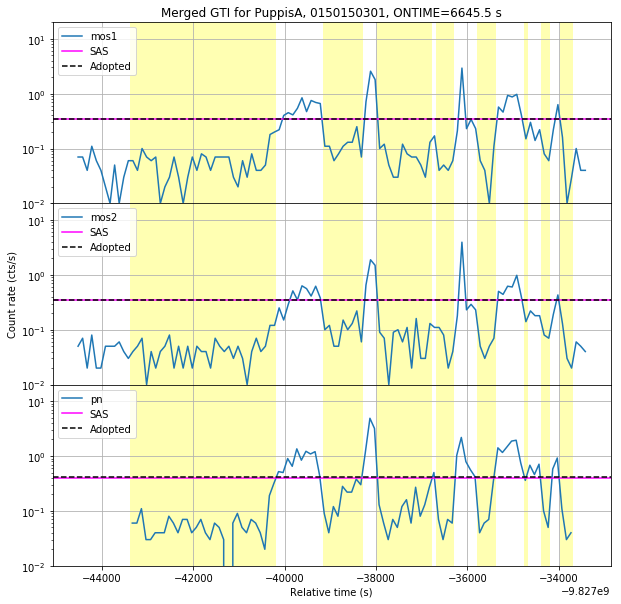

In [42]:
# step 3a
#
# plot the lightcurve and the GTI per detector and the merged one
#
f, ax = plt.subplots(3, sharex=True, sharey=True,figsize=(10,10))
#
# get the good time intervals
#
hdu = fits.open(gti_merged,hdu=1)
start = hdu[1].data["START"]
end = hdu[1].data["STOP"]
mtime = hdu[1].header['ONTIME']
print (f"GTI Merged ONTIME {mtime}")
logging.info (f"GTI Merged ONTIME {mtime}")
#
ngti = len(start)
#
instruments = ['mos1','mos2','pn']

ratefiles = glob.glob(f"rate_*")

for i,j in enumerate(ratefiles):
    if ('mos1' in j):
        inst = 'mos1'
    if ('mos2' in j):
        inst = 'mos2'
    if ('pn' in j):
        inst = 'pn'
    hdu = fits.open(j)
    rate = hdu[1]
    hdu = fits.open(j.replace('rate','gti'))
    gti = hdu[1]
    #
    reltime = rate.data['TIME'] - time_min
    ax[i].semilogy(reltime,rate.data['RATE'],label=inst)
    if ('mos' in inst):
        rate_lim = 0.35
    else:
        rate_lim = 0.4
    #
    ax[i].axhline(y=rate_lim,color='magenta',ls='solid',label='SAS')
    #ax[i].axhline(y=medrate,color='r',ls='dashed',label='median')
    #ax[i].axhline(y=prate,color='b',ls='dashed',label='{}%'.format(perc))
    ax[i].axhline(y=use_limit[inst],color='k',ls='dashed',label='Adopted')
    #ax1.set_ylim([med-15,med+15])
    #ax[i].set_xlabel("Time (s)")
    #ax.set_ylabel("Count rate")
    ax[i].set_ylim((0.01,20.0))
    ax[i].grid(True)
    #if (i == 0):
    ax[i].legend(loc=2)
    #if (i == 0):
    #    ax[i].legend(loc=2)
    if (i == 1):
        ax[i].set_ylabel("Count rate (cts/s)")
    #
    # now the GTI bands
    #
    for jj in np.arange(ngti):
        xx = (start[jj]-time_min,end[jj]-time_min)
        yy1 = (0.01,0.01)
        yy2 = (20.0,20.0)
        ax[i].fill_between(xx,yy1,yy2,facecolor='yellow',alpha=0.3)
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("Relative time (s)")
ax[0].set_title(f"Merged GTI for {target}, {obsid}, ONTIME={mtime:.1f} s")
#
#png_file = "{}/{}_rates_gti.png".format(ppsDir,obsid)
#plt.savefig(png_file,dpi=100)
plt.show()
#logging.info("Saved GTI limits in figure: {}".format(png_file))
plt.close();


## Create filtered event lists

The filtering of the event lists is using the standard flags and either the user provided GTI file or the ones generated during the previous step. The GTI files can be per detector or a merged one.

In [43]:
#**Step 4:** Create GTI filtered event lists, using the GTI file
#
# using the merged GTI
gtifile = gti_merged
#gtifile = f"{root_dir}/{target}/{target}_GTI.fits"
#
#skip_expo = ["S011","S012","S013"]
for jl in evlists:
    expo = jl.split('_')[3]
    #if (expo in skip_expo):
    #    print (f"Skip exposure {expo}")
    #    logging.warning (f"Skip exposure {expo}")
    #    continue
    if ('_EMOS1' in jl):
        if (gtifile == None):
            expr = f"#XMMEA_EM && gti(gti_mos1_{expo}.fits,TIME) && (PI>150)"
        else:
            expr = f"#XMMEA_EM && gti({gtifile},TIME) && (PI>150)"
        inst = 'mos1'
    elif ('_EMOS2' in jl):
        if (gtifile == None):
            expr = f"#XMMEA_EM && gti(gti_mos2_{expo}.fits,TIME) && (PI>150)"
        else:
            expr = f"#XMMEA_EM && gti({gtifile},TIME) && (PI>150)"
        inst = 'mos2'
    elif ('_EPN' in jl):
        if (gtifile == None):
            expr = f"#XMMEA_EP && gti(gti_pn_{expo}.fits,TIME) && (PI>150)"
        else:
            expr = f"#XMMEA_EP && gti({gtifile},TIME) && (PI>150)"
        inst = 'pn'
    else:
        raise Exception(f'Cannot identify the instrument in {jl}')
    #
    ev_command = f'evselect table={jl} withfilteredset=Y filteredset={inst}_evlist_clean.fits' +  \
        f' destruct=Y keepfilteroutput=T expression=\'{expr}\''
    #
    print (f"Filtering {inst} with GTI")
    status = run_command(ev_command)
    if (status != 0):
        print (f"Command \"{ev_command}\" failed.")
        raise Exception
#

Filtering mos1 with GTI


Execution of evselect table=0649_0150150301_EMOS1_S001_ImagingEvts.ds withfilteredset=Y filteredset=mos1_evlist_clean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EM && gti(PuppisA_0150150301_gti_merged.fits,TIME) && (PI>150)' returned 0


Filtering mos2 with GTI


Execution of evselect table=0649_0150150301_EMOS2_S002_ImagingEvts.ds withfilteredset=Y filteredset=mos2_evlist_clean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EM && gti(PuppisA_0150150301_gti_merged.fits,TIME) && (PI>150)' returned 0


Filtering pn with GTI


Execution of evselect table=0649_0150150301_EPN_S003_ImagingEvts.ds withfilteredset=Y filteredset=pn_evlist_clean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EP && gti(PuppisA_0150150301_gti_merged.fits,TIME) && (PI>150)' returned 0


## Generating images

Once we have the clean event lists we can use them to generate images in user-provided energy ranges. There is a large flexibility in the choices for the event selection (patterns, flags etc) and the output image properties, e.g. the pixel size. 

In [56]:
#**Step 5:** Generate images in user-selected energy range
pi0 = 500
pi1 = 7000
# image binning, 80 means 4" pixel
bin_size = 80
#
print (f"*** Generating images in band [{pi0},{pi1}] eV")
for inst in ['mos1','mos2','pn']:
    evlist = f'{inst}_evlist_clean.fits'
    if (not os.path.isfile(evlist)):
        print(f"Cannot find cleaned event lists for {inst}. Image will not be generated.")
        continue
    image_name = f'{inst}_image_{pi0}_{pi1}.fits'
    #
    if ('mos' in inst):
        expr = f'PI in [{pi0}:{pi1}] &&  #XMMEA_EM && PATTERN in [0:12]'
    else:
        expr = f'PI in [{pi0}:{pi1}] &&  FLAG==0 && PATTERN in [0:4]'
    #    
    ev_command = f'evselect table={evlist} xcolumn=X ycolumn=Y imagebinning=binSize' +  \
         f' ximagebinsize={bin_size} yimagebinsize={bin_size}' + \
         f' expression=\'{expr}\'' +  \
         f' withimageset=true imageset={image_name}'
    status = run_command(ev_command)
    if (status != 0):
        raise Exception

*** Generating images in band [500,7000] eV


Execution of evselect table=mos1_evlist_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PI in [500:7000] &&  #XMMEA_EM && PATTERN in [0:12]' withimageset=true imageset=mos1_image_500_7000.fits returned 0
Execution of evselect table=mos2_evlist_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PI in [500:7000] &&  #XMMEA_EM && PATTERN in [0:12]' withimageset=true imageset=mos2_image_500_7000.fits returned 0
Execution of evselect table=pn_evlist_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PI in [500:7000] &&  FLAG==0 && PATTERN in [0:4]' withimageset=true imageset=pn_image_500_7000.fits returned 0


In [57]:
#
# Display the images using pyds9
# 
import pyds9 

d = pyds9.DS9('ds9run')

imagefiles = glob.glob("*_image_*.fits")
d.set("height 600")
d.set("width 1800")
d.set("tile mode column")
#
# region radius
#
radius = 0.5 # one arcmin
#
for k,j in enumerate(imagefiles):
    hdu = fits.open(j)
    ra_c = hdu[0].header['RA_OBJ']
    dec_c = hdu[0].header['DEC_OBJ']
    if (k > 0):
        d.set("frame new")
        d.set("tile")
    d.set(f"file {j}")
    #d.set("zoom to fit")
    d.set("zoom 1.5")
    d.set("scale asinh")
    d.set("cmap gray")
    d.set(f"regions command \"fk5; circle ({ra_c},{dec_c},{radius}\') # color=red\"")
d.set("match frames wcs")
#
# allow to edit the regions (move, resize etc.)
d.set("mode region")

1

In [61]:
#
# now print the regons in detector coorindates
#
d.set('regions system physical')
reg = d.get('regions list close')
for q in reg.split():
    if ('circle' in q):
        src_reg = q
        break
    #
print (src_reg)

circle(25813.417,27938.997,600)


## Generate exposure maps, count-rate and detector mask images(optional)

This step is optional but it is needed in some cases, e.g. for combining MOS and pn images into a merged one you need the count-rate image.

In [60]:
# step 5b
# generate the exposure image and the detector mask
#
cif_file = f"{pps_dir}/ccf.cif"
if (not os.path.isfile(cif_file)):
    print (f"Cannot find CCF file {cif_file}. Please set it")
    logging.error (f"Cannot find CCF file {cif_file}. Please set it")
    raise FileNotFoundError
os.environ['SAS_CCF'] = cif_file
#
do_detmask = True
do_crimage = True
print ("*** Generating exposure maps")
#
# need the attitude file
atthk = glob.glob("*_AttHk.ds")
if (not os.path.isfile(atthk[0])):
    print("Cannot find Attitude HK file, cannot continue.")
    raise FileNotFoundError
#
for inst in ['mos1','mos2','pn']:
    evlist = f'{inst}_evlist_clean.fits'
    image_name = f'{inst}_image_{pi0}_{pi1}.fits'
    if (not os.path.isfile(image_name)):
        print("Cannot find image {image_name}, cannot produce exposure image and detector mask.")
        continue
    #
    expfile = f"{inst}_expimage_{pi0}_{pi1}.fits"
    xcommand = f'eexpmap imageset={image_name} attitudeset={atthk[0]}' + \
    f' eventset={evlist} expimageset={expfile} pimin={pi0} pimax={pi1}'
    status = run_command(xcommand)
    if (status != 0):
        raise Exception
    #
    # now the detector map
    #
    if (do_detmask):
        detfile = f"{inst}_detmask_{pi0}_{pi1}.fits"
        xcommand = f'emask expimageset={expfile} detmaskset={detfile}' + \
        ' threshold1=0.3 threshold2=0.5'
        status = run_command(xcommand)
        if (status != 0):
            raise Exception
    #
    # now the count-rate image
    #
    if (do_crimage):
        crfile = f"{inst}_crimage_{pi0}_{pi1}.fits"
        hdu0 = fits.open(image_name)
        hdu1 = fits.open(expfile)
        # avoid division by zero 
        crdata = np.divide(hdu0[0].data,hdu1[0].data,where=(hdu1[0].data > 0.0))
        # the count-rate image will have the same header as the original image
        hdu0[0].data = crdata
        hdu0.writeto(crfile)
        hdu1.close()
        hdu0.close()
#

*** Generating exposure maps


Execution of eexpmap imageset=mos1_image_500_7000.fits attitudeset=0649_0150150301_AttHk.ds eventset=mos1_evlist_clean.fits expimageset=mos1_expimage_500_7000.fits pimin=500 pimax=7000 returned 0
Execution of emask expimageset=mos1_expimage_500_7000.fits detmaskset=mos1_detmask_500_7000.fits threshold1=0.3 threshold2=0.5 returned 0
Execution of eexpmap imageset=mos2_image_500_7000.fits attitudeset=0649_0150150301_AttHk.ds eventset=mos2_evlist_clean.fits expimageset=mos2_expimage_500_7000.fits pimin=500 pimax=7000 returned 0
Execution of emask expimageset=mos2_expimage_500_7000.fits detmaskset=mos2_detmask_500_7000.fits threshold1=0.3 threshold2=0.5 returned 0
Execution of eexpmap imageset=pn_image_500_7000.fits attitudeset=0649_0150150301_AttHk.ds eventset=pn_evlist_clean.fits expimageset=pn_expimage_500_7000.fits pimin=500 pimax=7000 returned 0
Execution of emask expimageset=pn_expimage_500_7000.fits detmaskset=pn_detmask_500_7000.fits threshold1=0.3 threshold2=0.5 returned 0


## Instrument specific part, only processing EPIC-pn

### Source spectrum extraction


In [62]:
#**Step 6:** Generate a spectrum from a user provided region file. This also runs `backscale` on the source spectrum.
#
# this is per instrument and we only process PN at this stage.
#
inst = "pn"
#regfile = f"{pps_dir}/../../{target}_{obsid}_region.reg"
#if (not os.path.isfile(regfile)):
#    print (f"Cannot find region file {regfile}. Cannot continue.")
#    logging.error (f"Cannot find region file {regfile}. Cannot continue.")
#    raise FileNotFoundError
##
#with open(regfile) as reg:
#    reg_line = reg.readline()
#src_reg = reg_line.strip().split()[0]
#
print (src_reg)
#
evlist = f'{inst}_evlist_clean.fits'
spec_name = f'{target}_{obsid}_{inst}_spectrum_src.fits'
#
if ('pn' in inst):
    spec_chan_max = 20479
    expr1 = "(FLAG==0) && (PATTERN<=4)"
else:
    spec_chan_max = 11999
    expr1 = "#XMMEA_EM && (PATTERN<=12)"
#
ev_command = f"evselect table={evlist} withspectrumset=yes spectrumset={spec_name}" +  \
f" energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax={spec_chan_max}" +  \
f" expression='{expr1} && ((X,Y) IN {src_reg})'"
status = run_command(ev_command)
if (status != 0):
    raise Exception
#
# Now backscale the source spectrum
#
print ("*** Backscale the source spectrum")
xcommand = f"backscale spectrumset={spec_name} badpixlocation={evlist}"
status = run_command(xcommand)
if (status != 0):
    raise Exception

circle(25813.417,27938.997,600)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=PuppisA_0150150301_pn_spectrum_src.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(25813.417,27938.997,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=PuppisA_0150150301_pn_spectrum_src.fits badpixlocation=pn_evlist_clean.fits returned 0


### Background spectrum extraction (optional)

In [ ]:
#**Step 6b:** Generate the background spectrum from a user provided region file. This also runs `backscale` on the source spectrum.
#
# this is per instrument and we only process PN at this stage.
#
#inst = "pn"
#regfile = f"{pps_dir}/{target}_{obsid}_bkg_region.reg"
#with open(regfile,'r') as reg:
#    reg_line = reg.readline()
#src_reg = reg_line.strip().split()[0]
#
print (bkg_reg)
#
evlist = f'{inst}_evlist_clean.fits'
spec_name = f'{target}_{obsid}_{inst}_spectrum_bkg.fits'
#
if ('pn' in inst):
    spec_chan_max = 20479
    expr1 = "(FLAG==0) && (PATTERN<=4)"
else:
    spec_chan_max = 11999
    expr1 = "#XMMEA_EM && (PATTERN<=12)"
#
ev_command = f"evselect table={evlist} withspectrumset=yes spectrumset={spec_name}" +  \
f" energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax={spec_chan_max}" +  \
f" expression='{expr1} && ((X,Y) IN {bkg_reg})'"
status = run_command(ev_command)
if (status != 0):
    raise Exception
#
# Now backscale the source spectrum
#
print ("*** Backscale the source spectrum")
xcommand = f"backscale spectrumset={spec_name} badpixlocation={evlist}"
status = run_command(xcommand)
if (status != 0):
    raise Exception

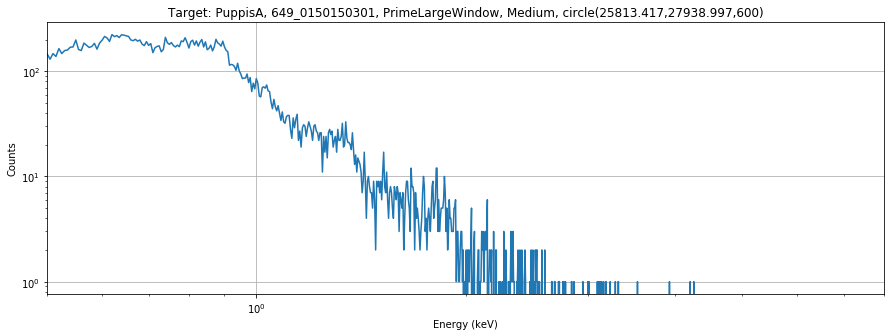

In [85]:
#
# display the spectrum
#
#fig, ax = plt.subplots(figsize=(15,10))
hdu = fits.open(spec_name)
qrev = hdu[0].header['REVOLUT']
qsubmode = hdu[0].header['SUBMODE']
qfilt = hdu[0].header['FILTER']
plot_title = f"Target: {target}, {qrev}_{obsid}, {qsubmode}, {qfilt}, {src_reg}"
#
spec = hdu['SPECTRUM']
binsize = spec.header['SPECDELT']
x = spec.data['CHANNEL']*binsize/1000.0
y = spec.data['COUNTS']
xlims  = (0.5, 8.0)
#
fig = plt.figure(figsize=(15,5))
ax = fig.subplots()
ax.loglog(x,y)
#ax.step(a[1][1:],a[0],color='red')
#ax.step(x,y,color='red')
ax.set_xlim(xlims)
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")
ax.set_title(plot_title)
ax.grid()
plt.savefig(f"{pps_dir}/{target}_{obsid}_src.png",dpi=100)
plt.show()
plt.close();

### Generate the RMF for the source spectrum

In [63]:
#**Step 7:** Generate an RMF file for the source spectrum
evlist = f'{inst}_evlist_clean.fits'
if (not os.path.isfile(evlist)):
    print("Cannot find cleaned event lists")
    raise FileNotFoundError
spec_name = f'{target}_{obsid}_{inst}_spectrum_src.fits'
if (not os.path.isfile(spec_name)):
    print (f"Cannot find source spectrum {spec_name}")
    raise FileNotFoundError
#
rmfset = f'{target}_{obsid}_{inst}_spectrum_src.rmf'
#
xcommand = f"rmfgen spectrumset={spec_name} rmfset={rmfset}"
print (f"*** Running {xcommand}")
status = run_command(xcommand)
if (status != 0):
    raise Exception

*** Running rmfgen spectrumset=PuppisA_0150150301_pn_spectrum_src.fits rmfset=PuppisA_0150150301_pn_spectrum_src.rmf


Execution of rmfgen spectrumset=PuppisA_0150150301_pn_spectrum_src.fits rmfset=PuppisA_0150150301_pn_spectrum_src.rmf returned 0


### Generate the ARF for the source extraction region

There wil be two calls to `arfgen`: one with the currently best way to get the ARF for extended source, using `badpixmaptype=dataset detmaptype=dataset` where the dataset is the MOS1 count-rate image (i.e. no vignetting).

The other call is with no bad pixel correction and flat detector map. The output ARF in ths case will have `test0` in the name.

In [20]:
#**Step 8:** Generate the ARF
arfset = f'{target}_{obsid}_{inst}_spectrum_src.arf'
# flat detector map (not good for extended sources), for SAS before 17 yo uhave to use this
xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
    f" badpixlocation={evlist} detmaptype=flat extendedsource=yes"
#
# MOS1 detector map (better for extended sources)
#mos1file = "mos1_crimage_500_7000.fits"
# better to have the MOS1 count-rate image, so that the vignetting is not applied twice!
#
#xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
#    f"  withbadpixcorr=yes badpixlocation={evlist} badpixmaptype=dataset detmaptype=dataset detmaparray={mos1file} extendedsource=yes"
print (f"*** Running {xcommand}")
status = run_command(xcommand)
if (status != 0):
    raise Exception

*** Running arfgen spectrumset=Coma_0300530101_pn_spectrum_src.fits arfset=Coma_0300530101_pn_spectrum_src.arf withrmfset=yes rmfset=Coma_0300530101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits detmaptype=flat extendedsource=yes


Execution of arfgen spectrumset=Coma_0300530101_pn_spectrum_src.fits arfset=Coma_0300530101_pn_spectrum_src.arf withrmfset=yes rmfset=Coma_0300530101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits detmaptype=flat extendedsource=yes returned 0


In [ ]:
# now the ARF with bad pixel correction and flat det
arfset = f'{target}_{obsid}_{inst}_test1.arf'
xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
    f"  withbadpixcorr=yes extendedsource=yes"
print (f"*** Running {xcommand}")
status = run_command(xcommand)
if (status != 0):
    raise Exception

In [ ]:
# now the ARF with no bad pixel correction
arfset = f'{target}_{obsid}_{inst}_test0.arf'
xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
    f"  withbadpixcorr=no extendedsource=yes"
print (f"*** Running {xcommand}")
status = run_command(xcommand)
if (status != 0):
    raise Exception

In [ ]:
# now the ARF with badpixel correction using a symtetic cluster image (generated with simulate_xmm_clusters)
#
arfset = f'{target}_{obsid}_{inst}_test2.arf'
simimage = 'pn_image_500_7000_sim_nodet.fits'
if (not os.path.isfile(simimage)):
    print (f"No detmaparray file {simimage} found. Please correct it.")
    logging.error(f"No detmaparray file {simimage} found. Please correct it.")
    raise FileNotFoundError
xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
    f"  withbadpixcorr=yes badpixlocation={evlist} badpixmaptype=dataset detmaptype=dataset detmaparray={simimage} extendedsource=yes"
print (f"*** Running {xcommand}")
status = run_command(xcommand)
if (status != 0):
    raise Exception

In [ ]:
#
# do the 3 ratios of the ARFs
#
# 0 is baseline with no badpixcorr
arf0 = fits.open(f'{target}_{obsid}_{inst}_test0.arf') 
# 1 is with MOS1 count-rate image
arf1 = fits.open(f'{target}_{obsid}_{inst}_spectrum_src.arf')
#arf1 = fits.open(f'{target}_{obsid}_{inst}_test1.arf')
# 2 is with syntetic image
#arf2 = fits.open(f'{target}_{obsid}_{inst}_test2.arf')
#
x0 = arf0['SPECRESP'].data["ENERG_LO"]
ix = np.where((x0 >= 0.5) & (x0 <= 2.0))[0]
#
y0 = arf0['SPECRESP'].data["SPECRESP"]
y1 = arf1['SPECRESP'].data["SPECRESP"]
#y2 = arf2['SPECRESP'].data["SPECRESP"]
#
ratio10 = y1/y0
ratio20 = y2/y0
print (f"{target}: Mean ratio 1/0 (MOS1CR): {np.mean(ratio10[ix]):.3f}, 2/0 (synthetic): {np.mean(ratio20[ix]):.3f}")
logging.info (f"{target}: Mean ratio 1/0 (MOS1CR): {np.mean(ratio10[ix]):.3f}, 2/0 (synthetic): {np.mean(ratio20[ix]):.3f}")
#
# parse the logfile for the geometric area in bad pixels:
with open(f'{pps_dir}/{target}_{obsid}_{pps}.log','r') as xlog:
    lines = xlog.readlines()
for iline in lines:
    if ("chip gap fraction:" in iline):
        print (iline)

In [ ]:
print ("*** All done.")
logging.info ("*** All done.")

In [ ]:
1-np.mean(ratio10[ix])